# Analyze A/B Test Results

## Table of Contents

- Part I - Probability
- Part II - A/B Test
- Part III - Regression

### Part I - Probability

In [105]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

import warnings
warnings.filterwarnings('ignore')

In [106]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [107]:
df.shape

(294478, 5)

In [108]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

In [109]:
# the number of rows where group and landing_page have mismatches
len(df[(df['group'] == 'control') & (df['landing_page'] == 'new_page')])+len(df[(df['group'] == 'treatment') & (df['landing_page'] == 'old_page')])

3893

In [110]:
# drop rows with mismatches and reset index
df_1 = df[~((df['group']=='control') & (df['landing_page']=='new_page'))]
df_filtered = df_1[~((df['group']=='treatment') & (df['landing_page']=='old_page'))]
df_filtered.reset_index()
df_filtered.shape

(290585, 5)

In [111]:
df_filtered.nunique() # There is still one duplicated row

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

In [112]:
# find out duplicated value
df_filtered[df_filtered.duplicated('user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [113]:
# drop duplicated value
df_filtered = df_filtered[~df_filtered.duplicated('user_id')]
df_filtered.reset_index()
df_filtered.nunique()

user_id         290584
timestamp       290584
group                2
landing_page         2
converted            2
dtype: int64

In [114]:
# conversion rate across both groups
df_filtered['converted'].mean()

0.11959708724499628

In [115]:
# conversion rate of control group
df_filtered[df_filtered['group'] == 'control']['converted'].mean()

0.1203863045004612

In [116]:
# conversion rate of treatment group
df_filtered[df_filtered['group'] == 'treatment']['converted'].mean()

0.11880806551510564

In [117]:
# the probability of receving the new group
len(df_filtered[df_filtered['group'] == 'treatment'])/len(df_filtered)

0.5000619442226688

There is no sufficient evidence to conclude that the new page leads to higher conversion rate as the conversion rate for both groups is at very similar level. In addition, the conversion rate of the control group is even slightly higher than the treatment group

### Part II - A/B Testing

- Null Hypothesis: p_new - p_old <= 0 
- Alternative Hypothesis: p_new - p_old > 0

In [118]:
# create the control and treatment dataframe
df_old = df_filtered[df_filtered['group'] == 'control']
df_new = df_filtered[df_filtered['group'] == 'treatment']

In [119]:
# sample size of both group
n_old = len(df_old)
n_new = len(df_new)
print(n_old,n_new)

145274 145310


#### 1. Simulation method

In [120]:
# p_old and p_new under null hypothesis
p_old = df_filtered['converted'].mean()
p_new = df_filtered['converted'].mean()

In [121]:
#simulate 10000 samples of the differences in conversion rates
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1 - p_new), p_new])
    old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1 - p_old), p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

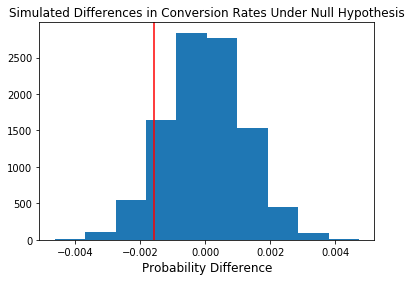

In [122]:
# plot the distribution of sample mean difference
obs_diff = df_filtered[df_filtered['group'] == 'treatment']['converted'].mean()-df_filtered[df_filtered['group'] == 'control']['converted'].mean()
plt.hist(p_diffs)
plt.title("Simulated Differences in Conversion Rates Under Null Hypothesis", fontsize=12)
plt.xlabel("Probability Difference", fontsize=12)
plt.axvline(obs_diff, color='r');

In [123]:
# calculate observed difference
obs_diff = df_filtered[df_filtered['group'] == 'treatment']['converted'].mean()-df_filtered[df_filtered['group'] == 'control']['converted'].mean()
obs_diff

-0.0015782389853555567

In [124]:
# calculate p_value
(p_diffs>=obs_diff).mean()

0.9065

As the p-value is 0.9, which is significantly higher than αlevel of 0.05, therefore we fail to reject the null hypothesis.This indicates there there is no significant difference in conversion rate between the new and old webpages.

#### 2. Use built-in stats package

In [125]:
import statsmodels.api as sm

In [126]:
converted_old = df_old[df_old['converted']==1]['converted'].count()
converted_new = df_new[df_new['converted']==1]['converted'].count()
converted_old, converted_new, n_old, n_new

(17489, 17264, 145274, 145310)

In [127]:
# use stats proportions z-test package 
z_score, p_value = sm.stats.proportions_ztest([converted_new, converted_old], [n_new, n_old], alternative='larger')
z_score, p_value
#In the two sample test, smaller means that the alternative hypothesis is p1 < p2 and larger means p1 > p2 where p1 is the proportion of the first sample and p2 of the second one.

(-1.3109241984234394, 0.9050583127590245)

### Part III - Regression

The goal is to use logistic regression a. to see if there is a significant difference in conversion based on which page a customer receives.

- Step 1: create a column for the intercept
- Step 2: create a dummy variable column for which page each user received - 1 for treatment and 0 for control

In [128]:
# add a column for the intercept
df_filtered['intercept'] = 1

In [129]:
# get dummy variable for landing_page column
df_filtered[['new_page','old_page']] = pd.get_dummies(df['landing_page'])

In [130]:
df_filtered.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


In [131]:
# apply logistic model
logit_mod = sm.Logit(df_filtered['converted'], df_filtered[['intercept', 'new_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [132]:
# summary of the model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 27 May 2020   Pseudo R-squ.:               8.077e-06
Time:                        19:18:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
new_page      -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

The p-value associated with new_page is 0.19. It is different from the p-value found in Part II because logistic regression is based on a two-tailed test. As 0.19 is higher than the alpha value of 0.05, we fail to reject the null hypothesis. 

The conversion rate can be potentially related to other user properties such as country, gender, age etc. Adding additional information to the model will reveal the effect of these variables on conversion rate.Here I will add the country feature to the model.

In [133]:
df_country = pd.read_csv('countries.csv')
df_country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [134]:
# create a new dataframe by adding country feature
df_updated = pd.merge(df_filtered, df_country, left_on = 'user_id', right_on = 'user_id', how = 'left')
df_updated.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,US


In [135]:
df_updated.info() # all users are mapped to a country

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 290583
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290584 non-null  int64 
 1   timestamp     290584 non-null  object
 2   group         290584 non-null  object
 3   landing_page  290584 non-null  object
 4   converted     290584 non-null  int64 
 5   intercept     290584 non-null  int64 
 6   new_page      290584 non-null  uint8 
 7   old_page      290584 non-null  uint8 
 8   country       290584 non-null  object
dtypes: int64(3), object(4), uint8(2)
memory usage: 18.3+ MB


In [136]:
df_updated['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [137]:
df_updated = pd.get_dummies(df_updated, columns=['country'])

In [138]:
df_updated.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,country_CA,country_UK,country_US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,0,1


In [139]:
# apply logistic model
log_mod_2 = sm.Logit(df_updated['converted'], df_updated[['intercept','new_page', 'country_UK','country_US']])
result = log_mod_2.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 27 May 2020   Pseudo R-squ.:               2.323e-05
Time:                        19:18:24   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
new_page      -0.0149      0.011     -1.307      0.191      -0.037       0.007
country_UK     0.0506      0.028      1.784      0.074      -0.005       0.106
country_US     0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

The p-values for the countries are above 0.05, so again we cannot reject the null hypothesis. Countries do not lead to significant difference in conversion rate

Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion. 

In [140]:
df_updated['new_page_uk'] = df_updated['new_page'] * df_updated['country_UK']
df_updated['new_page_us'] = df_updated['new_page'] * df_updated['country_US']
df_updated.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,country_CA,country_UK,country_US,new_page_uk,new_page_us
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,0,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,0,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,0,1,0,0


In [141]:
# apply logistic model
log_mod_3 = sm.Logit(df_updated['converted'], df_updated[['intercept','new_page', 'country_UK','country_US','new_page_uk','new_page_us']])
result = log_mod_3.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 27 May 2020   Pseudo R-squ.:               3.482e-05
Time:                        19:18:26   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -2.0040      0.036    -55.008      0.000      -2.075      -1.933
new_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
country_UK      0.0118      0.040      0.296      0.767      -0.066       0.090
country_US      0.0175      0.038      0.465      0.642      -0.056       0.091
new_page_uk     0.0783      0.057      1.378      0.168      -0.033       0.190
new_page_us     0.0469      0.054      0.872      0.383      -0.059       0.152
===============================================================================
"""

Looking at p-values for all variables (all higher than 0.05), we can conclude that interactions between page and country have no significant effects on conversion rate

## Conclusion

The analysis shows that we do not have sufficient evidence to conclude that he new webpage leads to higher conversion rate than the old one. Even though there can be other user properties potentially resulting in rejecting the null hypothesis, the analysis done so-far suggests that the new website doesn't bring additional value and we should keep the old webpage instead. 